# NetPyNE Tutorial 1: Simulating a simple network

In this tutorial, we will create a simple network model we can simulate. The model will consist of 40 pyramidal-like, two-compartment neurons with standard Hodgkin-Huxley dynamics in the somas and passive dynamics in the dendrites. We will connect the neurons randomly with a 10% probability of connection using a standard double-exponential synapse model. Finally, we will add a current clamp stimulus to one cell to activate the network. Then we will explore the model.

## Preliminaries

If you are going to run this notebook locally using Jupyter Notebook, start from following instructions https://github.com/suny-downstate-medical-center/netpyne/blob/development/netpyne/tutorials/README.md.

If you are using Open Source Brain or EBRAINS, everything is already set up.

On any other online platform (e.g. on Google Collab) you might need to run the following commmands to install NEURON and NetPyNE using **pip**:
```
!pip install neuron
!pip install netpyne
```

Now we are ready to start the tutorial.

## Instantiate network parameters and simulation configuration

You need two things to define a model/simulation in NetPyNE: 1) the parameters of the network and all its components (**netParams**) and 2) the configuration of the simulation (**simConfig**).  These requirements exist as objects in NetPyNE.  Let's instantiate them now.

In [1]:
from netpyne import specs, sim

netParams = specs.NetParams()
simConfig = specs.SimConfig()

--No graphics will be displayed.


Now we are going to specify our model: a simple network of 40 pyramidal-like two-compartment neurons with standard Hodgkin-Huxley dynamics in the soma and passive dynamics in the dendrite.

## Specify a cell model

First we will add a cell type to our model by adding a dictionary named **pyr** to the *Cell Parameters* dictionary (**cellParams**) in the *Network Parameters* dictionary (**netParams**).  We will then add an empty dictionary named **secs** to hold our compartments.

In [2]:
netParams.cellParams["pyr"] = {}
netParams.cellParams["pyr"]["secs"] = {}

### Specify the soma compartment properties


Now we will define our **soma**, by adding a **geom** dictionary defining the geometry of the soma and a **mechs** dictionary defining the biophysical mechanics being added to the soma.

In [3]:
netParams.cellParams["pyr"]["secs"]["soma"] = {}

In [4]:
netParams.cellParams["pyr"]["secs"]["soma"]["geom"] = {
    "diam": 12,
    "L": 12,
    "Ra": 100.0,
    "cm": 1,
}

In [5]:
netParams.cellParams["pyr"]["secs"]["soma"]["mechs"] = {
    "hh": {"gnabar": 0.12, "gkbar": 0.036, "gl": 0.0003, "el": -54.3}
}

The **hh** mechanism is builtin to NEURON, but you can see its *.mod* file here:
https://github.com/neuronsimulator/nrn/blob/master/src/nrnoc/hh.mod

It is the original Hodgkin-Huxley treatment for the set of sodium, potassium, and leakage channels found in the squid giant axon membrane.

### Specify the dendrite compartment properties


Next will do the same thing for the dendrite compartment, but we will do it slightly differently.  We will first build up a **dend** dictionary and then add it to the cell model dictionary **pyr** when we are done.

In [6]:
dend = {}

In [7]:
dend["geom"] = {
    "diam": 1.0,
    "L": 200.0,
    "Ra": 100.0,
    "cm": 1,
}

In [8]:
dend["mechs"] = {"pas": {"g": 0.001, "e": -70}}

The **pas** mechanim is a simple leakage channel and is builtin to NEURON.  Its *.mod* file is available here:
https://github.com/neuronsimulator/nrn/blob/master/src/nrnoc/passive.mod

In order to connect the dendrite compartment to the soma compartment, we must add a **topol** dictionary to our **dend** dictionary.

In [9]:
dend["topol"] = {
    "parentSec": "soma",
    "parentX": 1.0,
    "childX": 0,
}

With our **dend** section dictionary complete, we must now add it to the **pyr** cell dictionary.

In [10]:
netParams.cellParams["pyr"]["secs"]["dend"] = dend

Our two-compartment cell model is now completely specified.  Our next step is to create a population of these cells.

## Specify a population of cells


NetPyNE uses *populations* of cells to specify connectivity.  In this tutorial, we will create just one population which we will call **E** (for excitatory).  It will be made of the **pyr** cells we just specified, and we want 40 of them.

In [11]:
netParams.popParams["E"] = {
    "cellType": "pyr",
    "numCells": 40,
}

## Specify a synaptic model


We need a synaptic mechanism to connect our cells with.  We will create one called **exc** by adding a dictionary to the *synaptic mechanism parameters* dictionary (**synMechParams**).  The synapse *mod* used (**Exp2Syn**) is a simple double-exponential which is builtin to NEURON.  It's *.mod* file is available here:
https://github.com/neuronsimulator/nrn/blob/master/src/nrnoc/exp2syn.mod

In [12]:
netParams.synMechParams["exc"] = {"mod": "Exp2Syn", "tau1": 0.1, "tau2": 1.0, "e": 0}

## Specify the connectivity


Now we will specify the connectivity in our model by adding an entry to the **connParams** dictionary.  We will call our connectivity rule **E->E** as it will define connectivity from our **E** population to our **E** population.

We will use the *synMech* **exc**, which we defined above.  For this synaptic mechanism, a *weight* of about **0.005** is appropriate.  These cells will have a 10% probability of getting connected, and will be activated five milliseconds after an action potential occurs in the presynaptic cell.  Synapses will occur on the **dend** *section* at its very end (*location* **1.0**)

In [13]:
netParams.connParams["E->E"] = {
    "preConds": {"pop": "E"},
    "postConds": {"pop": "E"},
    "weight": 0.005,
    "probability": 0.1,
    "delay": 5.0,
    "synMech": "exc",
    "sec": "dend",
    "loc": 1.0,
}

## Set up the simulation configuration

In [14]:
simConfig.filename = "netpyne_tut1"
simConfig.duration = 200.0
simConfig.dt = 0.1

We will record from from the first cell (**0**) and we will record the voltage in the middle of the soma and the end of the dendrite.

In [15]:
simConfig.recordCells = [0]
simConfig.recordTraces = {
    "V_soma": {
        "sec": "soma",
        "loc": 0.5,
        "var": "v",
    },
    "V_dend": {
        "sec": "dend",
        "loc": 1.0,
        "var": "v",
    },
}

Finally we will set up some plots to be automatically generated and saved.

In [16]:
simConfig.analysis = {
    "plotTraces": {
        "include": [0],
        "saveFig": True,
    },
    "plotRaster": {
        "saveFig": True,
    },
}

## Create, simulate, and analyze the model


The command `%matplotlib inline` allows figures to be shown in this notebook.

In [17]:
%matplotlib inline

Use one simple command to create, simulate, and analyze the model.


Start time:  2024-10-30 15:01:52.360471




Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 40 
  Done; cell creation time = 0.01 s.
Making connections...


  E->E: 100%|##########| Creating synaptic connections for 40/40 postsynaptic cells on node 0 (probabilistic connectivity)

  Number of connections on node 0: 161 
  Done; cell connection time = 0.02 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
Recording 2 traces of 2 types on node 0

Running simulation using NEURON for 200.0 ms...
  Done; run time = 0.03 s; real-time ratio: 7.00.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 40
  Connections: 161 (4.03 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.2 s; 1 workers
  Run time: 0.03 s
Plotting recorded cell traces ... cell


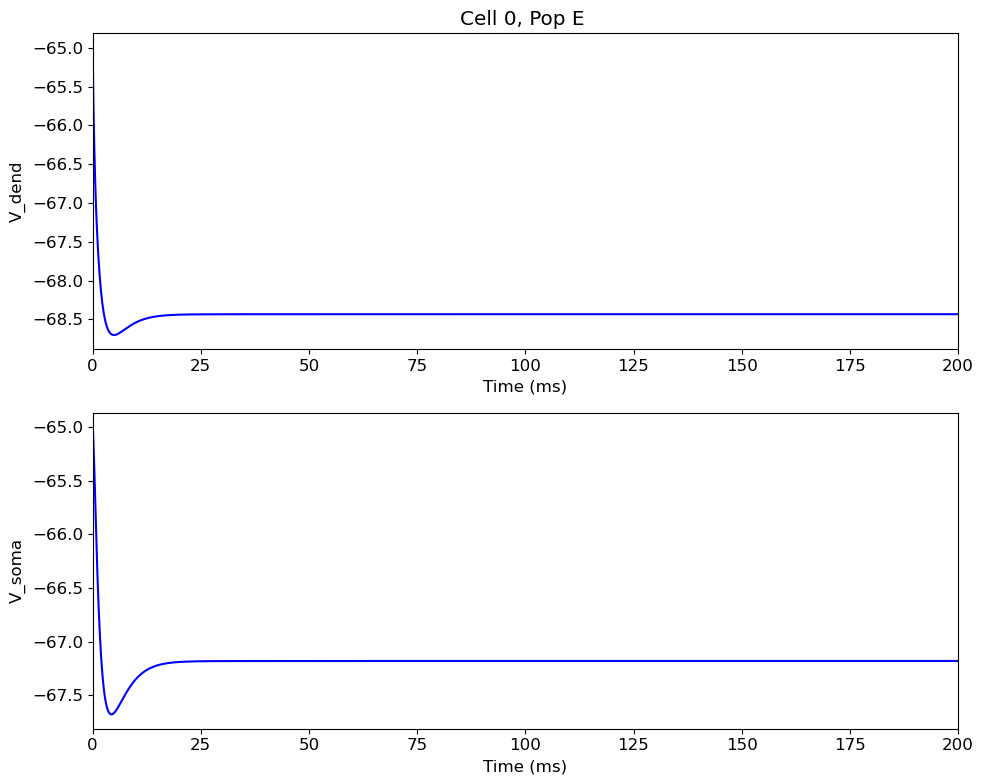

Preparing spike data...
No spikes available to plot raster
Plotting raster...

There was an exception in plotRaster()
  Done; plotting time = 0.40 s

Total time = 0.47 s


Traceback (most recent call last):
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/analysis/utils.py", line 75, in wrapper
    return function(*args, **kwargs)
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/plotting/plotRaster.py", line 277, in plotRaster
    popNumCells = [max(spkInds)]
UnboundLocalError: local variable 'spkInds' referenced before assignment


In [18]:
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

We can see that there was no spiking in the network, and thus the spike raster was not plotted.  But there should be one new file in your directory: **netpyne_tut1_traces.png**.  Take a look.  Not too interesting, the cell just settles into its resting membrane potential.

Let's overlay the traces.  You can see all the options available for **plotTraces** here: http://netpyne.org/netpyne.analysis.traces.html#netpyne.analysis.traces.plotTraces


Plotting recorded cell traces ... cell


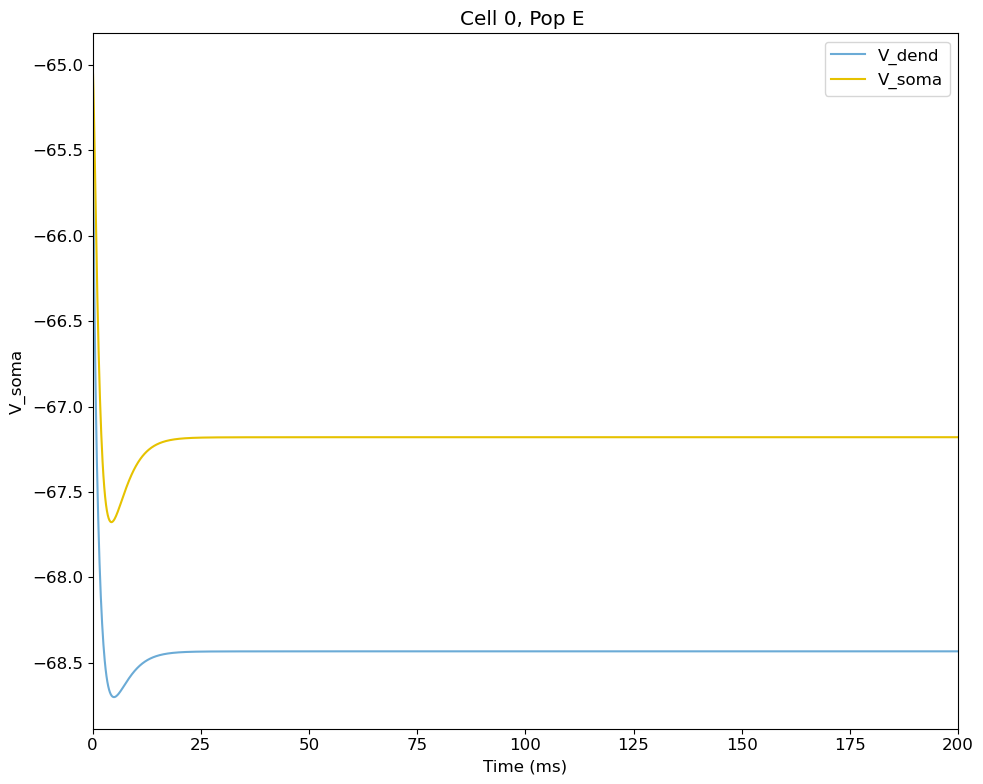

({'_gid_0': <Figure size 1000x800 with 1 Axes>},
 {'tracesData': [{'t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.998e+02, 1.999e+02,
           2.000e+02]),
    'cell_0_V_dend': array([-65.        , -65.41383301, -65.76123855, ..., -68.43343268,
           -68.43343268, -68.43343268])},
   {'t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.998e+02, 1.999e+02,
           2.000e+02]),
    'cell_0_V_soma': array([-65.        , -65.05541424, -65.14921876, ..., -67.17965663,
           -67.17965663, -67.17965663])}],
  'include': [0, 0]})

In [19]:
sim.analysis.plotTraces(overlay=True)

## Explore the model

### Plot the 2D connectivity of the network

Now we can take a look at the physical layout of our network model.  You can see all the options available for **plot2Dnet** here:
http://netpyne.org/netpyne.analysis.network.html#netpyne.analysis.network.plot2Dnet

Plotting 2D representation of network cell locations and connections...


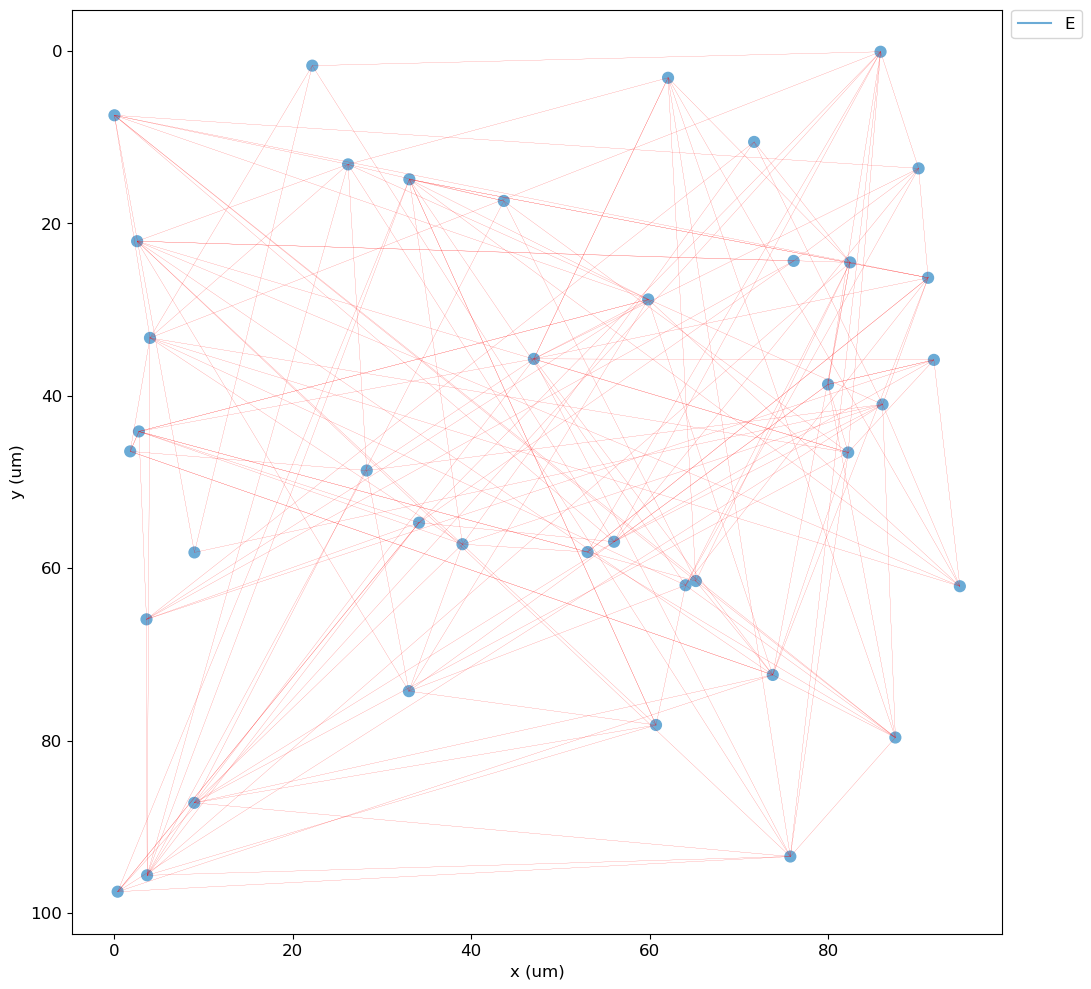

(<Figure size 1200x1200 with 1 Axes>,
 {'include': ['allCells'],
  'posX': [np.float64(33.079204118559325),
   np.float64(3.6220320492000244),
   np.float64(59.846707442811066),
   np.float64(73.80318996175119),
   np.float64(87.54329476795549),
   np.float64(85.88281586163612),
   np.float64(91.2131133044108),
   np.float64(82.25778560567232),
   np.float64(91.85780945889238),
   np.float64(34.164406700487156),
   np.float64(60.72220891697281),
   np.float64(47.03504528220858),
   np.float64(82.47309048136857),
   np.float64(75.7730980460129),
   np.float64(26.21266070608686),
   np.float64(8.978975375886314),
   np.float64(8.995616713306957),
   np.float64(43.66554570298978),
   np.float64(0.39106728499963245),
   np.float64(53.05320123372292),
   np.float64(71.71463529306588),
   np.float64(76.14741388798053),
   np.float64(79.99828318599651),
   np.float64(4.01355684641433),
   np.float64(39.03391534950726),
   np.float64(2.5726721150398553),
   np.float64(2.774977497110381),
   np

In [20]:
sim.analysis.plot2Dnet()

### Plot the connectivity matrix


You can see all the options available for **plotConn** here:
http://netpyne.org/netpyne.analysis.network.html#netpyne.analysis.network.plotConn

Plotting connectivity matrix...


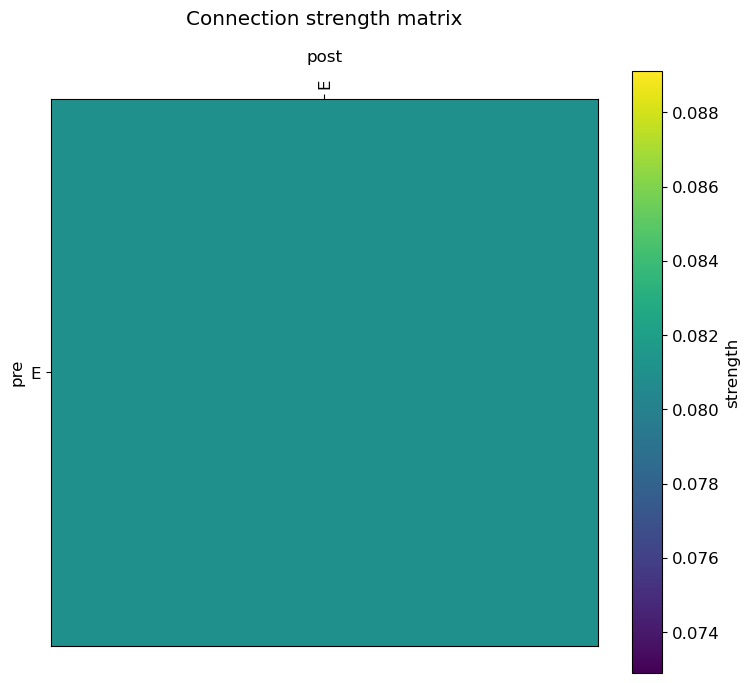

(<Figure size 800x800 with 2 Axes>,
 {'connMatrix': array([[0.08100313]]),
  'feature': 'strength',
  'groupBy': 'pop',
  'includePre': ['all'],
  'includePost': ['all']})

In [21]:
sim.analysis.plotConn()

Not very interesting with just one population, but we can also look at the cellular level connectivity.

Plotting connectivity matrix...


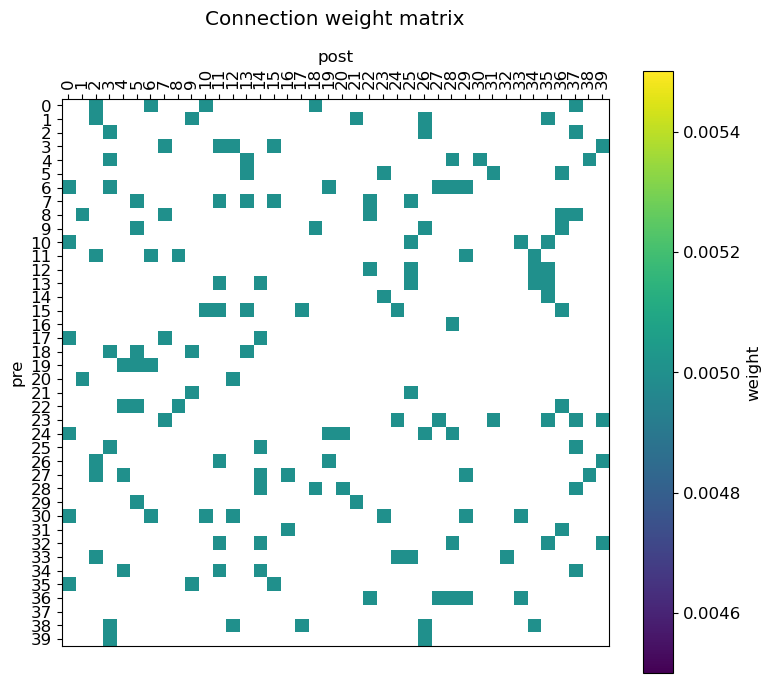

(<Figure size 800x800 with 2 Axes>,
 {'connMatrix': array([[  nan,   nan, 0.005, ..., 0.005,   nan,   nan],
         [  nan,   nan, 0.005, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ..., 0.005,   nan,   nan],
         ...,
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan]]),
  'feature': 'weight',
  'groupBy': 'cell',
  'includePre': ['all'],
  'includePost': ['all']})

In [22]:
sim.analysis.plotConn(feature="weight", groupBy="cell")

## Add a stimulation


We'll need to kickstart this network to see some activity -- let's inject current into one of the cells.  First we need to add an entry to the *Stimulation Source Parameters* dictionary (**stimSourceParams**).  We'll call our stimulation **IClamp1**, and we'll use the standard NEURON *type*: **IClamp**.  The current injection will last for a *duration* of 20 ms, it will start at a *delay* of 5 ms, and it will have an *amplitude* of 0.1 nanoAmps. 

In [23]:
netParams.stimSourceParams["IClamp1"] = {
    "type": "IClamp",
    "dur": 5,
    "del": 20,
    "amp": 0.1,
}

Now we need to add a target for our stimulation.  We do that by adding a dictionary to the *Stimulation Target Parameters* dictionary (**stimTargetParams**).  We'll call this connectivity rule **IClamp1->cell0**, because it will go from the source we just created (**IClamp1**) and the first cell in our population.  The stimulation (current injection in this case) will occur in our **dend** *section* at the very tip (*location* of **1.0**).

In [24]:
netParams.stimTargetParams["IClamp1->cell0"] = {
    "source": "IClamp1",
    "conds": {"cellList": [0]},
    "sec": "dend",
    "loc": 1.0,
}

Now we can re-run the simulation.


Start time:  2024-10-30 15:01:53.863077




Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 40 
  Done; cell creation time = 0.02 s.
Making connections...


  E->E: 100%|##########| Creating synaptic connections for 40/40 postsynaptic cells on node 0 (probabilistic connectivity)

  Number of connections on node 0: 161 
  Done; cell connection time = 0.03 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 2 traces of 2 types on node 0

Running simulation using NEURON for 200.0 ms...
  Done; run time = 0.03 s; real-time ratio: 6.75.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 40
  Connections: 161 (4.03 per cell)
  Spikes: 252 (31.50 Hz)
  Simulated time: 0.2 s; 1 workers
  Run time: 0.03 s
Plotting recorded cell traces ... cell


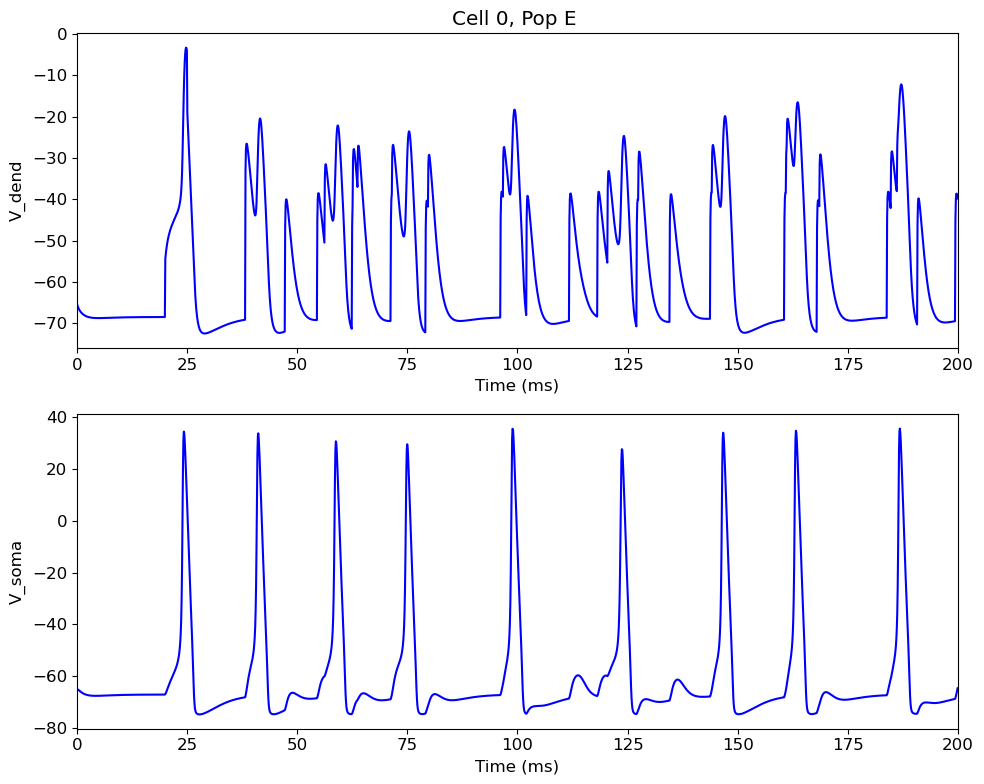

Preparing spike data...
Plotting raster...
  Done; plotting time = 0.52 s

Total time = 0.61 s


In [25]:
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

Now we see spiking in the network, and the raster plot appears.  Let's improve the plots a little bit.

Plotting recorded cell traces ... cell


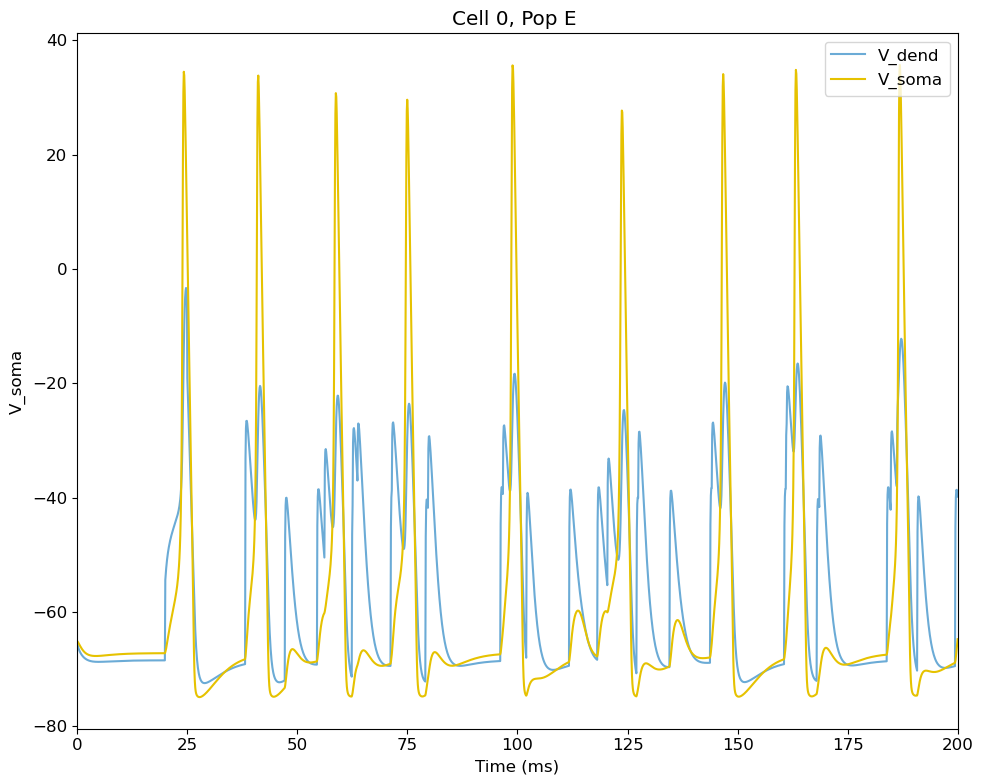

({'_gid_0': <Figure size 1000x800 with 1 Axes>},
 {'tracesData': [{'t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.998e+02, 1.999e+02,
           2.000e+02]),
    'cell_0_V_dend': array([-65.        , -65.41383301, -65.76123855, ..., -38.6143203 ,
           -39.09122302, -39.8155437 ])},
   {'t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.998e+02, 1.999e+02,
           2.000e+02]),
    'cell_0_V_soma': array([-65.        , -65.05541424, -65.14921876, ..., -66.3429646 ,
           -65.5226336 , -64.73478115])}],
  'include': [0, 0]})

In [26]:
sim.analysis.plotTraces(overlay=True)

Preparing spike data...
Plotting raster...


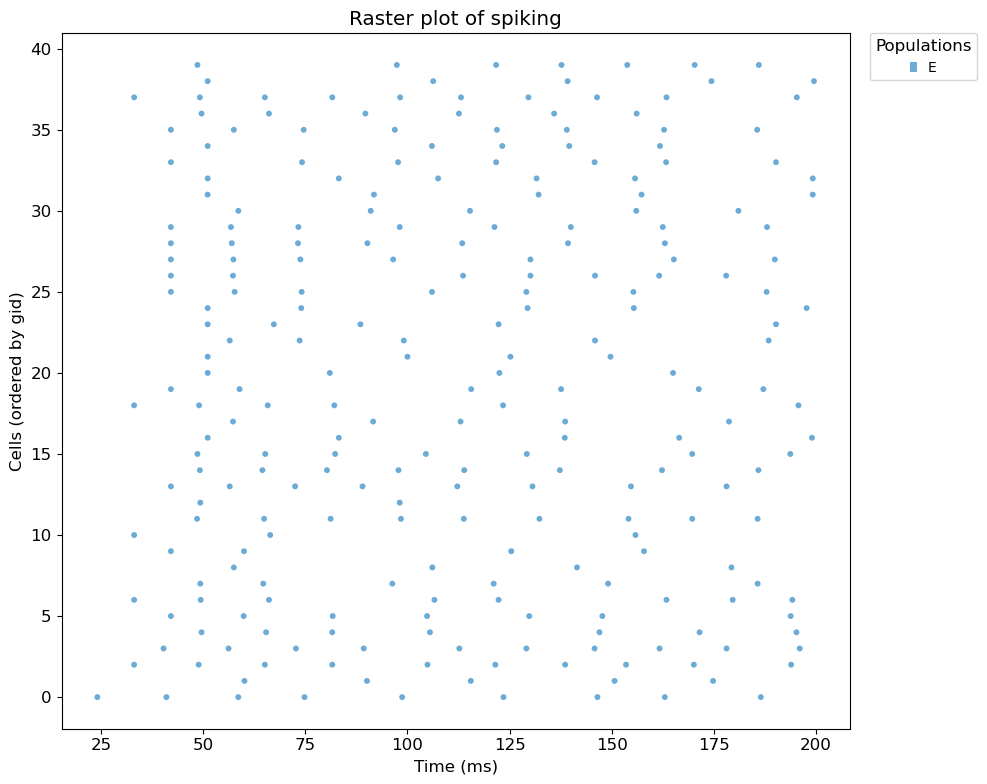

In [27]:
sim.analysis.plotRaster(marker="o", markerSize=50)

## Record and plot a variety of traces


Now let's explore the model by recording and plotting a variety of traces.  First let's clear our **recordTraces** dictionary and turn off the automatic raster plot.

In [28]:
simConfig.recordTraces = {}
simConfig.analysis["plotRaster"] = False

### Record and plot the somatic conductances


Let's record and plot the somatic conductances.  We need to take a look at the **hh** mod file to see what the variables are called.  The file is available here: https://github.com/neuronsimulator/nrn/blob/master/src/nrnoc/hh.mod

We can see that the conductances are called *gna*, *gk*, and *gl*.  Let's set up recording for these conductances in the middle of the soma.

In [29]:
simConfig.recordTraces["gNa"] = {"sec": "soma", "loc": 0.5, "mech": "hh", "var": "gna"}
simConfig.recordTraces["gK"] = {"sec": "soma", "loc": 0.5, "mech": "hh", "var": "gk"}
simConfig.recordTraces["gL"] = {"sec": "soma", "loc": 0.5, "mech": "hh", "var": "gl"}

Then we can re-run the simulation.


Start time:  2024-10-30 15:01:54.906211




Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 40 
  Done; cell creation time = 0.02 s.
Making connections...


  E->E: 100%|##########| Creating synaptic connections for 40/40 postsynaptic cells on node 0 (probabilistic connectivity)

  Number of connections on node 0: 161 
  Done; cell connection time = 0.03 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 3 traces of 3 types on node 0

Running simulation using NEURON for 200.0 ms...
  Done; run time = 0.03 s; real-time ratio: 6.69.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 40
  Connections: 161 (4.03 per cell)
  Spikes: 252 (31.50 Hz)
  Simulated time: 0.2 s; 1 workers
  Run time: 0.03 s
Plotting recorded cell traces ... cell


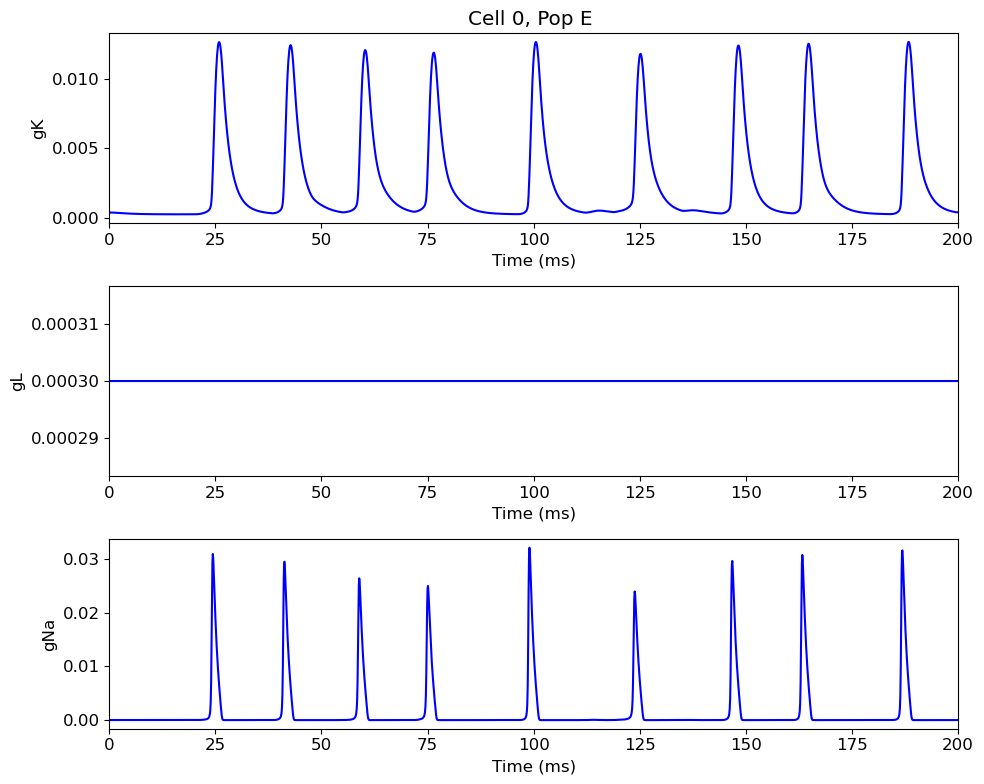

  Done; plotting time = 0.42 s

Total time = 0.50 s


In [30]:
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

Let's zoom in on one spike and overylay the traces.

Plotting recorded cell traces ... cell


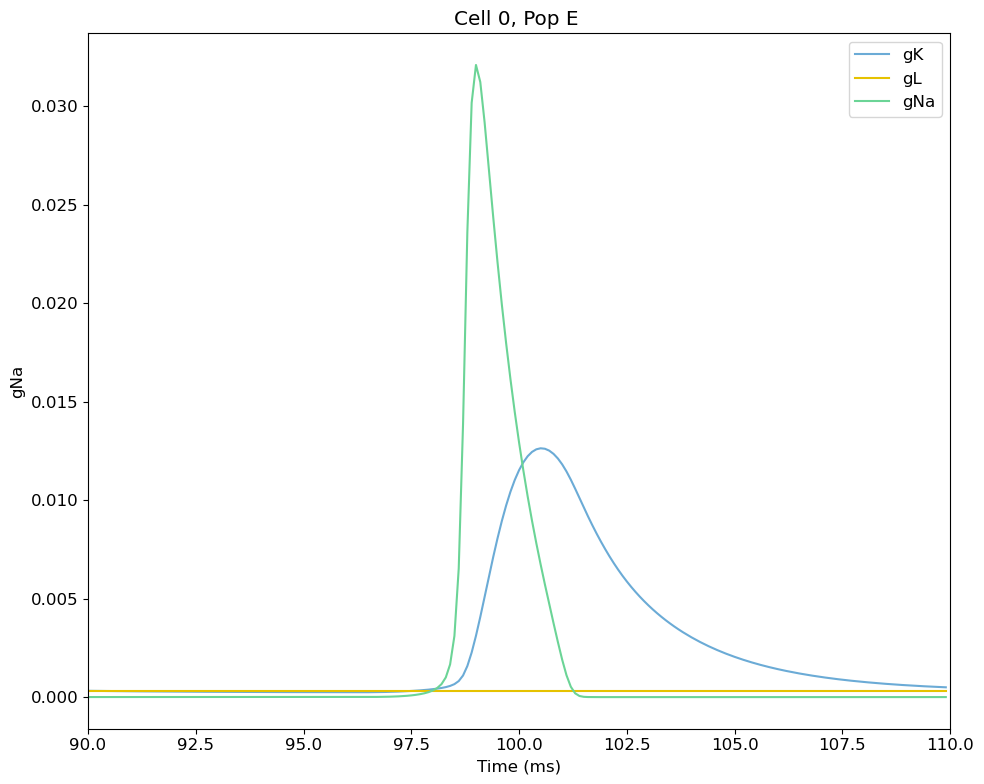

({'_gid_0': <Figure size 1000x800 with 1 Axes>},
 {'tracesData': [{'t': array([ 90. ,  90.1,  90.2,  90.3,  90.4,  90.5,  90.6,  90.7,  90.8,
            90.9,  91. ,  91.1,  91.2,  91.3,  91.4,  91.5,  91.6,  91.7,
            91.8,  91.9,  92. ,  92.1,  92.2,  92.3,  92.4,  92.5,  92.6,
            92.7,  92.8,  92.9,  93. ,  93.1,  93.2,  93.3,  93.4,  93.5,
            93.6,  93.7,  93.8,  93.9,  94. ,  94.1,  94.2,  94.3,  94.4,
            94.5,  94.6,  94.7,  94.8,  94.9,  95. ,  95.1,  95.2,  95.3,
            95.4,  95.5,  95.6,  95.7,  95.8,  95.9,  96. ,  96.1,  96.2,
            96.3,  96.4,  96.5,  96.6,  96.7,  96.8,  96.9,  97. ,  97.1,
            97.2,  97.3,  97.4,  97.5,  97.6,  97.7,  97.8,  97.9,  98. ,
            98.1,  98.2,  98.3,  98.4,  98.5,  98.6,  98.7,  98.8,  98.9,
            99. ,  99.1,  99.2,  99.3,  99.4,  99.5,  99.6,  99.7,  99.8,
            99.9, 100. , 100.1, 100.2, 100.3, 100.4, 100.5, 100.6, 100.7,
           100.8, 100.9, 101. , 101.1, 101.2

In [31]:
sim.analysis.plotTraces(timeRange=[90, 110], overlay=True)

### Record from synapses

Our synapses are set up to use **Exp2Syn**, which is builtin to NEURON.  Its mod file is available here: https://github.com/neuronsimulator/nrn/blob/master/src/nrnoc/exp2syn.mod

Looking in the file, we can see that its current variable is called **i**.  Let's record that and the voltages in the dendrite and soma.

In [32]:
simConfig.recordTraces = {}
simConfig.recordTraces["iSyn0"] = {
    "sec": "dend",
    "loc": 1.0,
    "synMech": "exc",
    "var": "i",
}
simConfig.recordTraces["V_dend"] = {"sec": "dend", "loc": 1.0, "var": "v"}
simConfig.recordTraces["V_soma"] = {"sec": "soma", "loc": 0.5, "var": "v"}


Start time:  2024-10-30 15:01:55.610347




Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 40 
  Done; cell creation time = 0.01 s.
Making connections...


  E->E: 100%|##########| Creating synaptic connections for 40/40 postsynaptic cells on node 0 (probabilistic connectivity)

  Number of connections on node 0: 161 
  Done; cell connection time = 0.04 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 3 traces of 3 types on node 0

Running simulation using NEURON for 200.0 ms...
  Done; run time = 0.03 s; real-time ratio: 6.72.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 40
  Connections: 161 (4.03 per cell)
  Spikes: 252 (31.50 Hz)
  Simulated time: 0.2 s; 1 workers
  Run time: 0.03 s
Plotting recorded cell traces ... cell


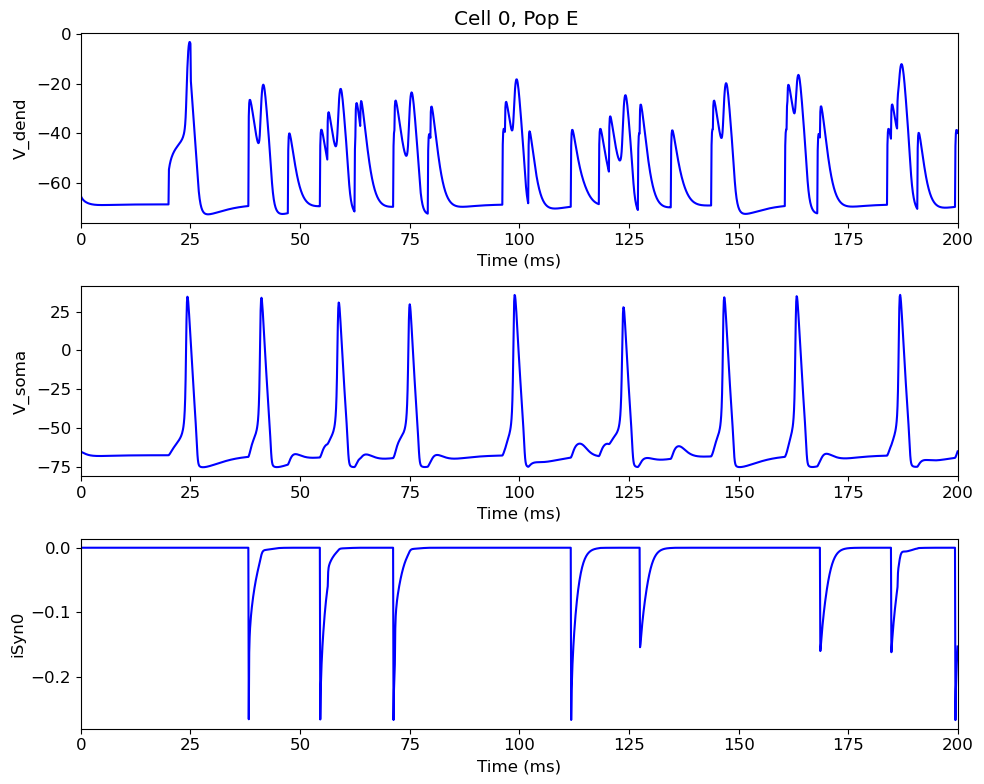

  Done; plotting time = 0.45 s

Total time = 0.53 s


In [33]:
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

That's the first synapse created in that location, but there are likely multiple synapses.  Let's plot all the synaptic currents entering cell 0.  First we need to see what they are.  The network is defined in **sim.net**.  Type in *sim.net.* and then push *Tab* to see what's available.

The data for cell 0 is in **sim.net.allCells[0]**.

In [34]:
sim.net.allCells[0].keys()

dict_keys(['gid', 'tags', 'conns', 'stims', 'secs', 'secLists'])

The connections coming onto the cell are in the **conns** dictionary.

In [35]:
sim.net.allCells[0]["conns"]

[{preGid: 6, sec: 'dend', loc: 1.0, synMech: 'exc', weight: 0.005, delay: 5.0, label: 'E->E', preLoc: 0.5},
 {preGid: 10, sec: 'dend', loc: 1.0, synMech: 'exc', weight: 0.005, delay: 5.0, label: 'E->E', preLoc: 0.5},
 {preGid: 17, sec: 'dend', loc: 1.0, synMech: 'exc', weight: 0.005, delay: 5.0, label: 'E->E', preLoc: 0.5},
 {preGid: 24, sec: 'dend', loc: 1.0, synMech: 'exc', weight: 0.005, delay: 5.0, label: 'E->E', preLoc: 0.5},
 {preGid: 30, sec: 'dend', loc: 1.0, synMech: 'exc', weight: 0.005, delay: 5.0, label: 'E->E', preLoc: 0.5},
 {preGid: 35, sec: 'dend', loc: 1.0, synMech: 'exc', weight: 0.005, delay: 5.0, label: 'E->E', preLoc: 0.5}]

So we want to record six synaptic currents.  Lets do that in a *for loop* at the same time creating a dictionary to hold the synaptic trace names as keys (and later the trace arrays as values).

In [36]:
simConfig.recordTraces = {}
simConfig.recordTraces["V_soma"] = {"sec": "soma", "loc": 0.5, "var": "v"}
simConfig.recordTraces["V_dend"] = {"sec": "dend", "loc": 1.0, "var": "v"}

syn_plots = {}
for index, presyn in enumerate(sim.net.allCells[0]["conns"]):
    trace_name = "i_syn_" + str(presyn["preGid"])
    syn_plots[trace_name] = None
    simConfig.recordTraces[trace_name] = {
        "sec": "dend",
        "loc": 1.0,
        "synMech": "exc",
        "var": "i",
        "index": index,
    }

Let's take a look at our **recordTraces** dictionary now.

In [37]:
simConfig.recordTraces

{'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'},
 'V_dend': {'sec': 'dend', 'loc': 1.0, 'var': 'v'},
 'i_syn_6': {'sec': 'dend',
  'loc': 1.0,
  'synMech': 'exc',
  'var': 'i',
  'index': 0},
 'i_syn_10': {'sec': 'dend',
  'loc': 1.0,
  'synMech': 'exc',
  'var': 'i',
  'index': 1},
 'i_syn_17': {'sec': 'dend',
  'loc': 1.0,
  'synMech': 'exc',
  'var': 'i',
  'index': 2},
 'i_syn_24': {'sec': 'dend',
  'loc': 1.0,
  'synMech': 'exc',
  'var': 'i',
  'index': 3},
 'i_syn_30': {'sec': 'dend',
  'loc': 1.0,
  'synMech': 'exc',
  'var': 'i',
  'index': 4},
 'i_syn_35': {'sec': 'dend',
  'loc': 1.0,
  'synMech': 'exc',
  'var': 'i',
  'index': 5}}

Now we'll run the simulation again so that these traces get recorded.


Start time:  2024-10-30 15:01:56.199423




Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 40 
  Done; cell creation time = 0.02 s.
Making connections...


  E->E: 100%|##########| Creating synaptic connections for 40/40 postsynaptic cells on node 0 (probabilistic connectivity)

  Number of connections on node 0: 161 
  Done; cell connection time = 0.12 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 8 traces of 8 types on node 0

Running simulation using NEURON for 200.0 ms...
  Done; run time = 0.03 s; real-time ratio: 6.58.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 40
  Connections: 161 (4.03 per cell)
  Spikes: 252 (31.50 Hz)
  Simulated time: 0.2 s; 1 workers
  Run time: 0.03 s
Plotting recorded cell traces ... cell


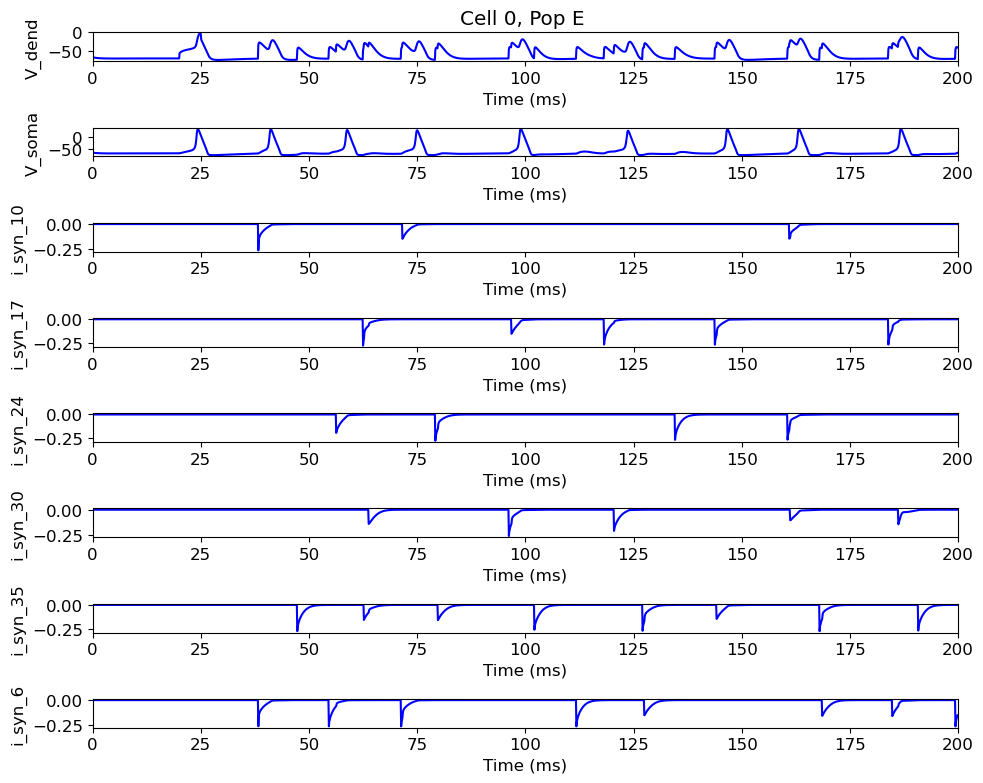

  Done; plotting time = 0.89 s

Total time = 1.07 s


In [38]:
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

## Extracting recorded data

Let's make our synaptic currents plot nicer.  We'll make a figure with two plots, the top one will be the somatic and dendritic voltage and the bottom plot will be all of the synaptic currents overlaid.

First we'll have to extract the data.  Simulation data gets stored in the dictionary **sim.allSimData**.

In [39]:
sim.allSimData.keys()

dict_keys(['spkt', 'spkid', 'V_soma', 'V_dend', 'i_syn_6', 'i_syn_10', 'i_syn_17', 'i_syn_24', 'i_syn_30', 'i_syn_35', 't', 'avgRate'])

**spkt** is an array of the times of all spikes in the network.  **spkid** is an array of the universal index (GID) of the cell spiking.   **t** is an array of the time for traces.  Our traces appear as we named them, and each is a dictionary with its key being **cell_GID** and its value being the array of the trace.

In [40]:
sim.allSimData.V_soma.keys()

dict_keys(['cell_0'])

So let's extract our data.

In [41]:
time = sim.allSimData["t"]
v_soma = sim.allSimData["V_soma"]["cell_0"]
v_dend = sim.allSimData["V_dend"]["cell_0"]

for syn_plot in syn_plots:
    syn_plots[syn_plot] = sim.allSimData[syn_plot]["cell_0"]

And now we can make our custom plot.

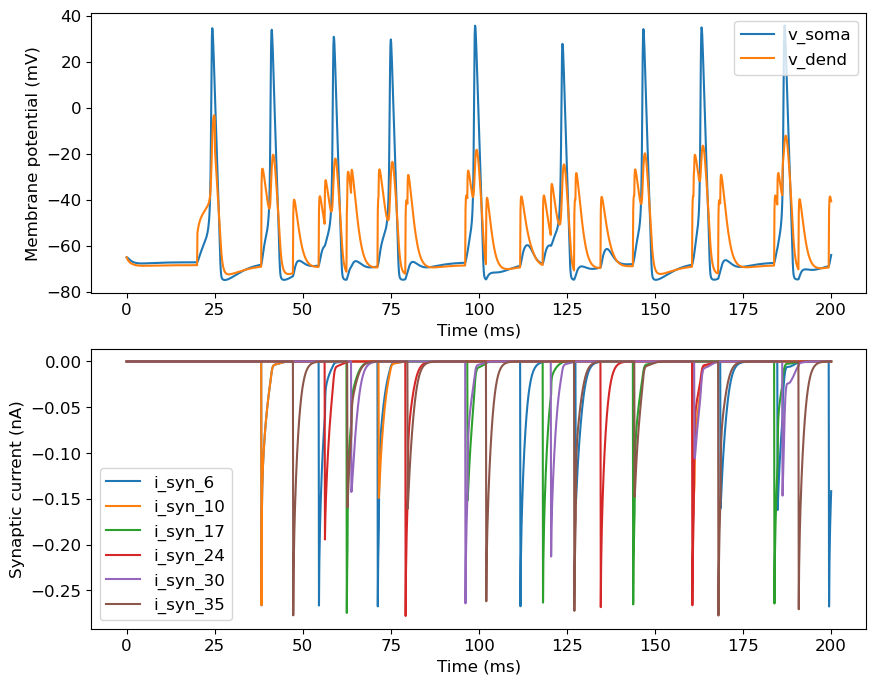

In [42]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10, 8])

plt.subplot(211)
plt.plot(time, v_soma, label="v_soma")
plt.plot(time, v_dend, label="v_dend")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")

plt.subplot(212)
for syn_plot in syn_plots:
    plt.plot(time, syn_plots[syn_plot], label=syn_plot)
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Synaptic current (nA)")

plt.savefig("syn_currents.jpg", dpi=600)

Congratulations!  You have simulated a network model by specifying parameters for cells, populations, synapses, connectivity, stimulations, and recording.  You explored some basic analyses and extracted data to make a custom plot.

Now we will put all of this together into a single file.

## This tutorial in a single Python file


Start time:  2024-10-30 15:01:58.181836




Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 40 
  Done; cell creation time = 0.01 s.
Making connections...


  E->E: 100%|##########| Creating synaptic connections for 40/40 postsynaptic cells on node 0 (probabilistic connectivity)

  Number of connections on node 0: 161 
  Done; cell connection time = 0.02 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 2 traces of 2 types on node 0

Running simulation using NEURON for 200.0 ms...
  Done; run time = 0.03 s; real-time ratio: 6.78.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 40
  Connections: 161 (4.03 per cell)
  Spikes: 252 (31.50 Hz)
  Simulated time: 0.2 s; 1 workers
  Run time: 0.03 s
Plotting recorded cell traces ... cell


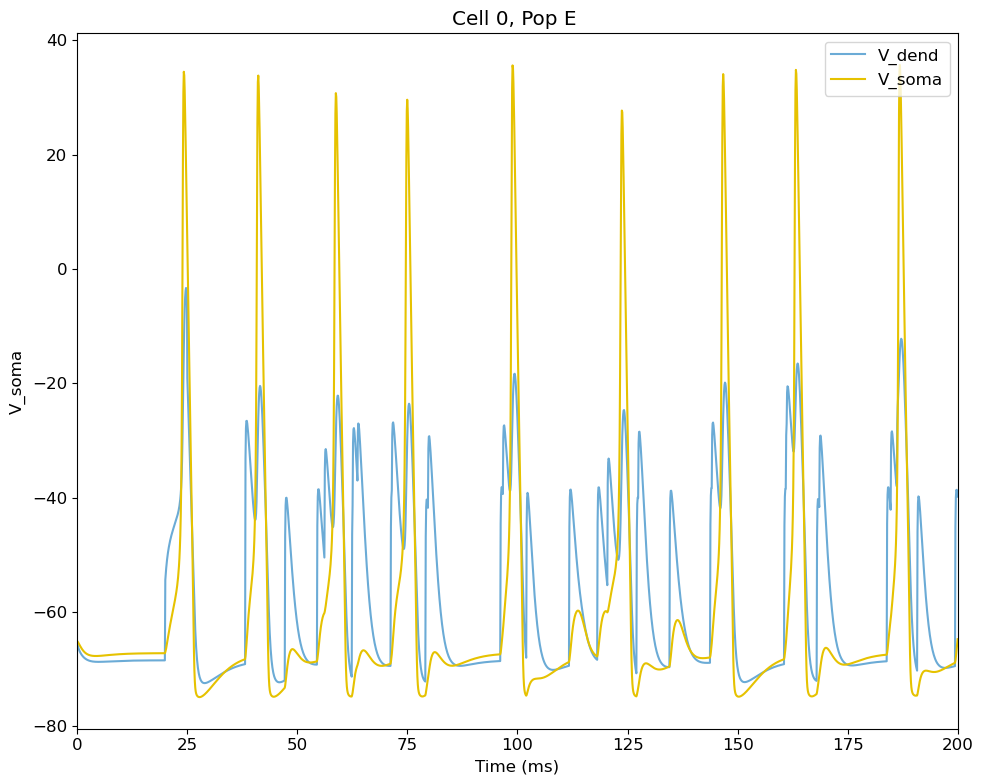

Preparing spike data...
Plotting raster...

There was an exception in plotConn()
Plotting 2D representation of network cell locations and connections...


Traceback (most recent call last):
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/analysis/utils.py", line 75, in wrapper
    return function(*args, **kwargs)
TypeError: plotConn() got an unexpected keyword argument 'groupby'


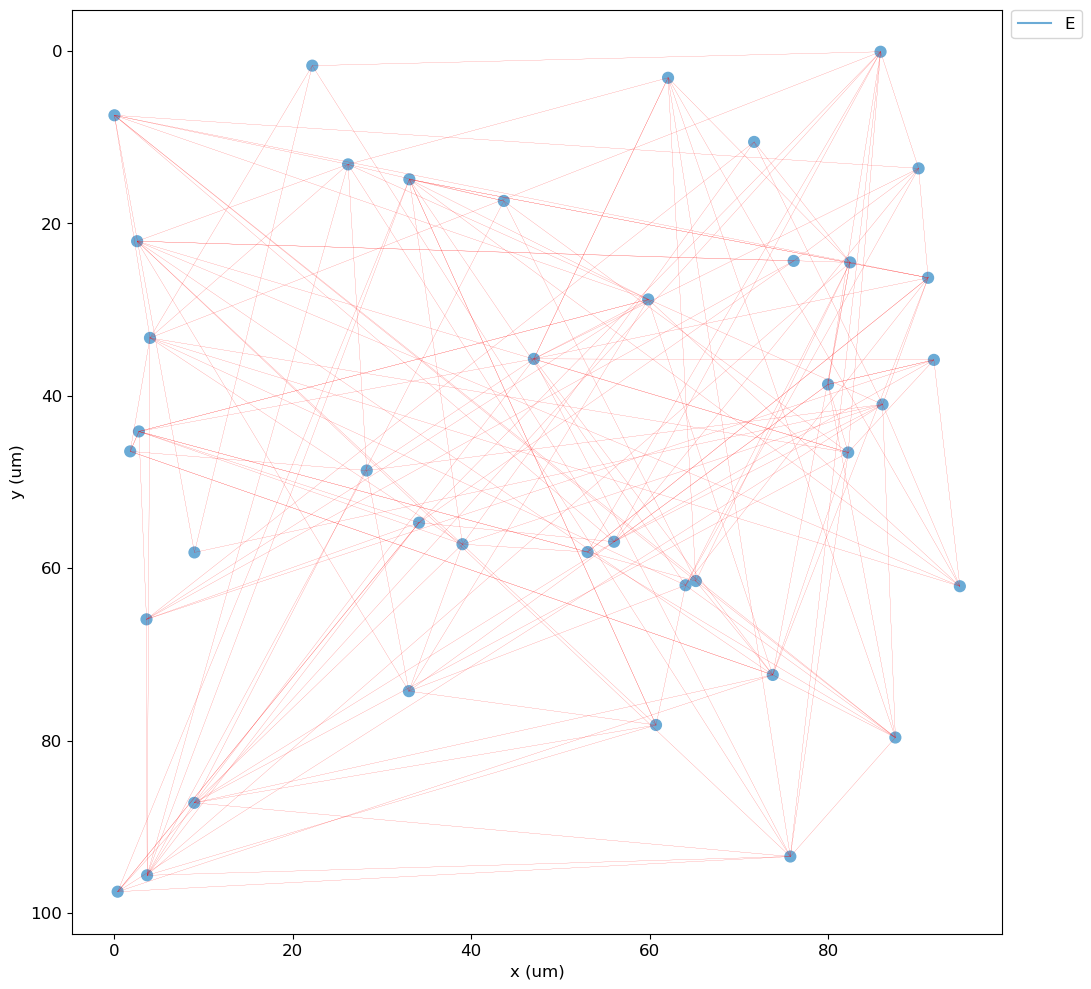

  Done; plotting time = 0.82 s

Total time = 0.88 s

Start time:  2024-10-30 15:01:59.065002




Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 40 
  Done; cell creation time = 0.01 s.
Making connections...


  E->E: 100%|##########| Creating synaptic connections for 40/40 postsynaptic cells on node 0 (probabilistic connectivity)

  Number of connections on node 0: 161 
  Done; cell connection time = 0.02 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 8 traces of 8 types on node 0

Running simulation using NEURON for 200.0 ms...
  Done; run time = 0.03 s; real-time ratio: 6.56.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 40
  Connections: 161 (4.03 per cell)
  Spikes: 252 (31.50 Hz)
  Simulated time: 0.2 s; 1 workers
  Run time: 0.03 s
Plotting recorded cell traces ... cell


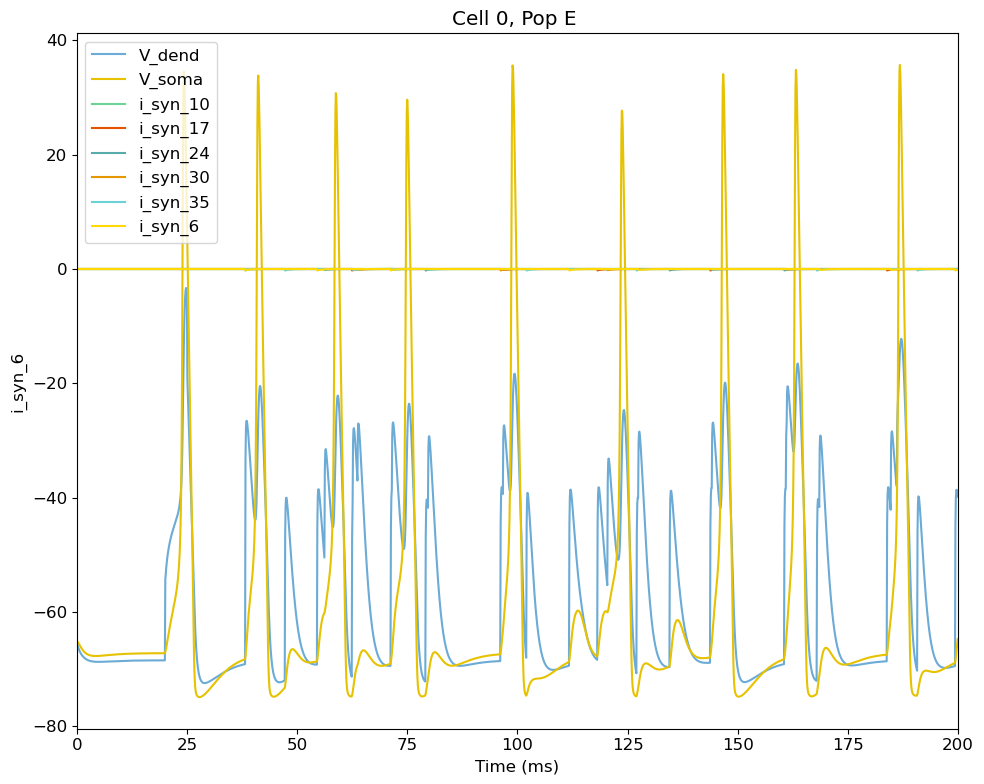

Preparing spike data...
Plotting raster...

There was an exception in plotConn()
Plotting 2D representation of network cell locations and connections...


Traceback (most recent call last):
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/analysis/utils.py", line 75, in wrapper
    return function(*args, **kwargs)
TypeError: plotConn() got an unexpected keyword argument 'groupby'


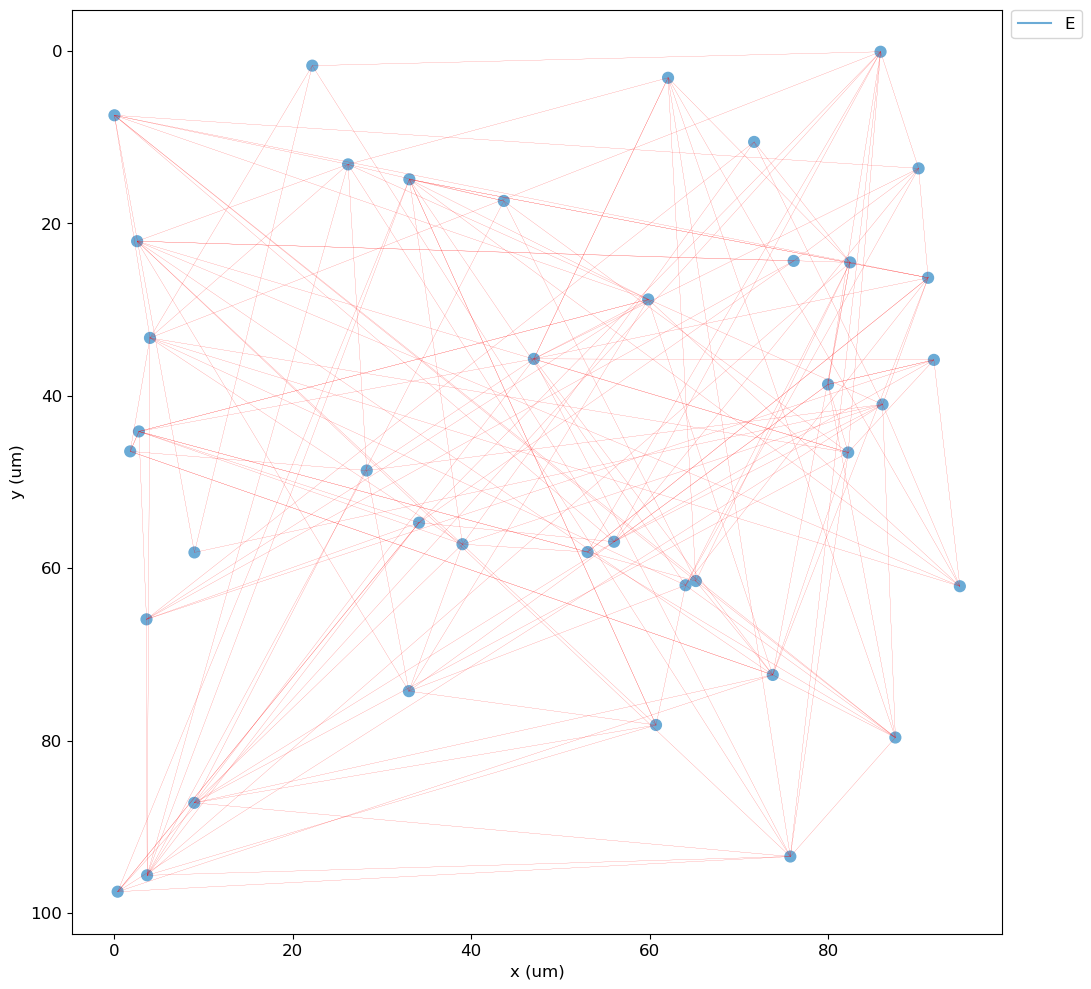

  Done; plotting time = 1.12 s

Total time = 1.18 s


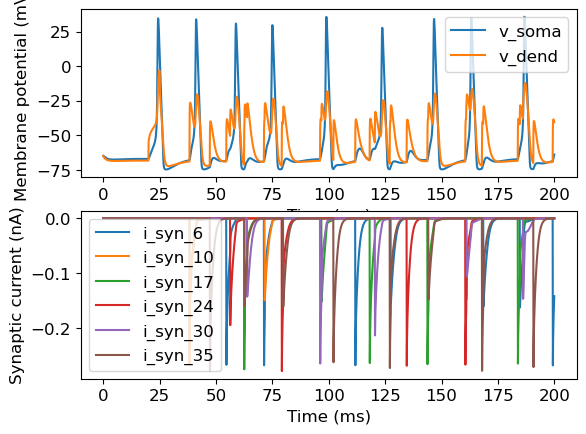

In [43]:
from netpyne import specs, sim

netParams = specs.NetParams()
simConfig = specs.SimConfig()

# Create a cell type
# ------------------

netParams.cellParams["pyr"] = {}
netParams.cellParams["pyr"]["secs"] = {}

# Add a soma section
netParams.cellParams["pyr"]["secs"]["soma"] = {}
netParams.cellParams["pyr"]["secs"]["soma"]["geom"] = {
    "diam": 12,
    "L": 12,
    "Ra": 100.0,
    "cm": 1,
}

# Add hh mechanism to soma
netParams.cellParams["pyr"]["secs"]["soma"]["mechs"] = {
    "hh": {"gnabar": 0.12, "gkbar": 0.036, "gl": 0.0003, "el": -54.3}
}

# Add a dendrite section
dend = {}
dend["geom"] = {
    "diam": 1.0,
    "L": 200.0,
    "Ra": 100.0,
    "cm": 1,
}

# Add pas mechanism to dendrite
dend["mechs"] = {"pas": {"g": 0.001, "e": -70}}

# Connect the dendrite to the soma
dend["topol"] = {
    "parentSec": "soma",
    "parentX": 1.0,
    "childX": 0,
}

# Add the dend dictionary to the cell parameters dictionary
netParams.cellParams["pyr"]["secs"]["dend"] = dend

# Create a population of these cells
# ----------------------------------
netParams.popParams["E"] = {
    "cellType": "pyr",
    "numCells": 40,
}

# Add Exp2Syn synaptic mechanism
# ------------------------------
netParams.synMechParams["exc"] = {"mod": "Exp2Syn", "tau1": 0.1, "tau2": 1.0, "e": 0}

# Define the connectivity
# -----------------------
netParams.connParams["E->E"] = {
    "preConds": {"pop": "E"},
    "postConds": {"pop": "E"},
    "weight": 0.005,
    "probability": 0.1,
    "delay": 5.0,
    "synMech": "exc",
    "sec": "dend",
    "loc": 1.0,
}

# Add a stimulation
# -----------------
netParams.stimSourceParams["IClamp1"] = {
    "type": "IClamp",
    "dur": 5,
    "del": 20,
    "amp": 0.1,
}

# Connect the stimulation
# -----------------------
netParams.stimTargetParams["IClamp1->cell0"] = {
    "source": "IClamp1",
    "conds": {"cellList": [0]},
    "sec": "dend",
    "loc": 1.0,
}

# Set up the simulation configuration
# -----------------------------------

simConfig.filename = "netpyne_tut1"
simConfig.duration = 200.0
simConfig.dt = 0.1

# Record from cell 0
simConfig.recordCells = [0]

# Record the voltage at the soma and the dendrite
simConfig.recordTraces = {
    "V_soma": {
        "sec": "soma",
        "loc": 0.5,
        "var": "v",
    },
    "V_dend": {
        "sec": "dend",
        "loc": 1.0,
        "var": "v",
    },
}

# Record somatic conductances
# simConfig.recordTraces['gNa'] = {'sec': 'soma', 'loc': 0.5, 'mech': 'hh', 'var': 'gna'}
# simConfig.recordTraces['gK'] = {'sec': 'soma', 'loc': 0.5, 'mech': 'hh', 'var': 'gk'}
# simConfig.recordTraces['gL'] = {'sec': 'soma', 'loc': 0.5, 'mech': 'hh', 'var': 'gl'}

# Automatically generate some figures
simConfig.analysis = {
    "plotTraces": {
        "include": [0],
        "saveFig": True,
        "overlay": True,
    },
    "plotRaster": {
        "saveFig": True,
        "marker": "o",
        "markerSize": 50,
    },
    "plotConn": {
        "saveFig": True,
        "feature": "weight",
        "groupby": "cell",
        "markerSize": 50,
    },
    "plot2Dnet": {
        "saveFig": True,
    },
}


# Create, simulate, and analyze the model
# ---------------------------------------
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)


# Set up the recording for the synaptic current plots
syn_plots = {}
for index, presyn in enumerate(sim.net.allCells[0]["conns"]):
    trace_name = "i_syn_" + str(presyn["preGid"])
    syn_plots[trace_name] = None
    simConfig.recordTraces[trace_name] = {
        "sec": "dend",
        "loc": 1.0,
        "synMech": "exc",
        "var": "i",
        "index": index,
    }


# Create, simulate, and analyze the model
# ---------------------------------------
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)


# Extract the data
# ----------------
time = sim.allSimData["t"]
v_soma = sim.allSimData["V_soma"]["cell_0"]
v_dend = sim.allSimData["V_dend"]["cell_0"]

for syn_plot in syn_plots:
    syn_plots[syn_plot] = sim.allSimData[syn_plot]["cell_0"]


# Plot our custom figure
# ----------------------
import matplotlib.pyplot as plt

fig = plt.figure()

plt.subplot(211)
plt.plot(time, v_soma, label="v_soma")
plt.plot(time, v_dend, label="v_dend")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")

plt.subplot(212)
for syn_plot in syn_plots:
    plt.plot(time, syn_plots[syn_plot], label=syn_plot)
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Synaptic current (nA)")

plt.savefig("syn_currents.jpg", dpi=600)